In [3]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.4.1


In [6]:
# Unzip images, ignore this cell if files are already in the workspace
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapGestRecog/07/06_index/frame_07_06_0027.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0028.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0029.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0030.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0031.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0032.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0033.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0034.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0035.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0036.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0037.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0038.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0039.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0040.png  
  inflating: leapGestRecog/07/06_index/frame_07_06_0041.png  
  inflating: leapGe

In [16]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

20000


In [8]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


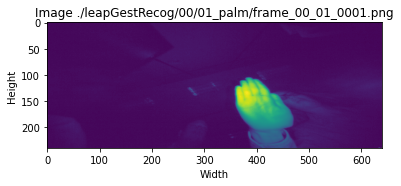

In [9]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

Now that we loaded the images and checked if it's everything we expected, we have to prepare the images to train the algorithm. We have to load all the images into an array that we will call **X** and all the labels into another array called **y**.

In [10]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20000
Labels loaded:  20000
1 ./leapGestRecog/00/01_palm/frame_00_01_0001.png


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd 'drive/MyDrive/Hand Geesture'


/content/drive/MyDrive/Hand Geesture


Scipy's train_test_split allows us to split our data into a training set and a test set. The training set will be used to build our model. Then, the test data will be used to check if our predictions are correct.  A random_state seed is used so the randomness of our results can be reproduced. The function will shuffle the images it's using to minimize training loss.


In [11]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [23]:
# Recreate the exact same model, including weights and optimizer.
model = keras.models.load_model('handrecognition_model.h5')
model.summary()

# To use the pre-trained model, just load it and skip to the next session.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 116, 316, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 158, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 156, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 78, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 76, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 38, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 31616)             0

In [12]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [13]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [14]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [15]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
219/219 - 826s - loss: 1.2237 - accuracy: 0.9149 - val_loss: 0.0043 - val_accuracy: 0.9988
Epoch 2/5
219/219 - 817s - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0031 - val_accuracy: 0.9988
Epoch 3/5
219/219 - 806s - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0036 - val_accuracy: 0.9988
Epoch 4/5
219/219 - 806s - loss: 0.0123 - accuracy: 0.9972 - val_loss: 0.0374 - val_accuracy: 0.9933
Epoch 5/5
219/219 - 805s - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0111 - val_accuracy: 0.9968


In [17]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 [==============================] - 79s 420ms/step - loss: 0.0111 - accuracy: 0.9968
Test accuracy: 99.68%


In [19]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [74]:
print(predictions[0])

[7.6553350e-09 5.3365463e-12 6.6221802e-14 9.4091200e-04 9.9905187e-01
 1.5330358e-10 7.5411162e-07 3.6658491e-06 2.4494583e-13 2.8287589e-06]


In [78]:
np.argmax(predictions[4]), y_test[4] # If same, got it right

(0, 0)

In [68]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    print(predicted_label)
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

1
4
6
0
0
6
6
9
1


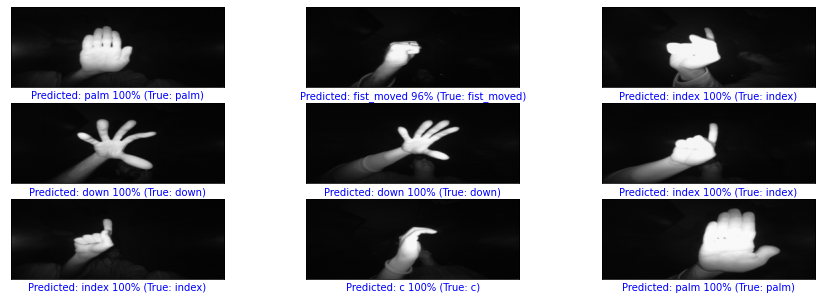

In [69]:
validate_9_images(predictions, y_test, X_test)

In [22]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [ ]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,604,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,617,0,1,0,0,0,0,0,0
Actual L,0,0,621,0,0,0,0,0,0,0
Actual Fist (H),0,0,0,605,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,596,0,0,0,0,0
Actual Thumbs up,0,0,0,0,0,600,0,0,0,0
Actual Index,0,0,0,0,0,0,568,0,0,0
Actual OK,0,0,0,0,0,0,0,586,0,0
Actual Palm (V),0,0,0,0,0,0,0,0,591,0
Actual C,0,0,0,0,0,0,0,0,0,611


Our Image


(120, 320)


Text(0.5, 1.0, 'Image ./archive.zip')

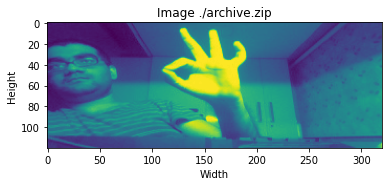

In [277]:


test_img = cv2.imread('/content/WIN_20210414_19_29_18_Pro.jpg') # Reads the image into a numpy.array
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
test_img = cv2.resize(test_img, (320, 120),interpolation = cv2.INTER_AREA)

print(test_img.shape) # Prints the shape of the image just to check
plt.grid(False) # Without grid so we can see better
plt.imshow(test_img) # Shows the image
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image " + path)


In [272]:
test_img = np.array(test_img, dtype="uint8")
test_img = test_img.reshape(1, 120, 320, 1)
#print(test_img)

In [273]:
test_predict = model.predict(test_img) # Make predictions towards the test set

In [274]:
#print(np.argmax(test_predict))

In [275]:
test_predicted_label = np.argmax(test_predict)
#print(test_predicted_label)

In [276]:
class_names = ["down", "palm", "L", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
print("Predicted image: {}".format(class_names[test_predicted_label]))

Predicted image: c
